In [1]:
#Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sci

import sklearn.ensemble as se
import sklearn.model_selection as ms
import sklearn.metrics as sm

import seaborn as sns
import math
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

from sklearn.inspection import permutation_importance
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import shap
shap.initjs()
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
#Import the preprocessed data
pd.set_option('display.max_columns',None)
new_df = pd.read_excel('Preprocessed AQY data.xlsx')
new_df = new_df.iloc[:,1:]
new_df.describe()

,Reference,DOM Category,Isolation way,Light Source,Wavelength Range,Actinometry,Temperature,pH,DOC,SUVA254,E2/E3,FIX,HIX,BIX,Φ3DOM*(10-2),Φ1O2(10-2),Φ·OH(10-4),TMP (mM),TMP Irradiation Time (h),Way of Second-order rate constant,k3DOM TMP (10-9 M-1 s-1),Inhibition Correction,kq (10-5 s-1),FFA (mM),FFA Irradiation Time (h),k1O2 FFA (10-8 M-1 s-1),kd (10-5 s-1),Correction for ·OH,Probe type,Probe (mM),Probe Irradiation Time (h),kProbe ·OH (10-9 M-1 s-1),Yield,Correction for DOC
count,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1060.000000,782.000000,488.000000,1133.000000,1081.000000,1089.000000,1089.000000,1089.000000,1089.000000,902.000000,894.000000,902.000000,902.000000,902.000000,530.000000,530.000000,521.000000,530.000000,530.000000,530.000000
mean,20.955994,2.429439,1.794385,1.745068,0.885432,2.402124,25.944613,7.467658,8.622508,6.405990,6.223145,1.608513,0.823663,0.698767,3.516741,3.407690,0.758458,0.102442,1.560102,0.440771,1.505799,0.611570,3.991234,0.066602,2.672058,1.097694,2.590355,1.121951,1.664151,1.075868,3.897601,5.084340,0.469736,0.950943
std,14.528412,0.867422,0.556100,0.551345,1.302908,0.824305,3.480825,0.931253,8.835632,3.857115,2.880980,0.292157,0.097357,0.182450,2.844457,2.512248,1.475032,0.255173,3.363596,0.496708,0.769424,0.636435,0.976663,0.176692,3.704958,0.121842,0.164461,0.639597,0.539934,1.154157,11.871466,1.725545,0.205567,0.748943
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,3.000000,0.430000,0.119526,1.685400,0.590000,0.240000,0.080000,0.093988,0.230000,0.013000,0.003670,0.250000,0.000000,0.450000,0.000000,2.520000,0.010000,0.500000,0.830000,2.400000,0.000000,0.000000,0.010000,0.500000,3.300000,0.155000,0.000000
25%,8.000000,2.000000,2.000000,2.000000,0.000000,2.000000,25.000000,7.000000,4.207500,3.915100,4.600000,1.470000,0.760171,0.598482,1.532500,1.645000,0.136000,0.005000,0.830000,0.000000,0.810000,0.000000,3.000000,0.010000,1.500000,1.000000,2.500000,1.000000,1.000000,0.010000,1.000000,4.200000,0.350000,0.000000
50%,16.000000,3.000000,2.000000,2.000000,0.000000,2.000000,25.000000,7.650950,6.300000,5.790265,5.520000,1.575505,0.852140,0.705000,2.790000,2.660000,0.310000,0.005000,1.000000,0.000000,1.310000,1.000000,3.200000,0.022500,2.000000,1.170000,2.500000,1.000000,2.000000,1.000000,1.000000,4.400000,0.350000,1.000000
75%,32.000000,3.000000,2.000000,2.000000,1.000000,2.000000,30.000000,8.064200,10.000000,8.060500,6.900000,1.668475,0.893000,0.808305,4.867500,4.467700,0.680750,0.010000,1.000000,1.000000,1.800000,1.000000,5.000000,0.050000,2.000000,1.200000,2.780000,2.000000,2.000000,2.000000,2.500000,7.800000,0.630000,2.000000
max,53.000000,3.000000,2.000000,2.000000,4.000000,4.000000,33.000000,9.700000,172.200000,27.313580,30.000000,3.110000,0.990000,2.250000,26.000000,17.020000,18.300000,1.000000,32.000000,1.000000,3.000000,2.000000,5.500000,1.000000,32.000000,1.220000,2.900000,2.000000,2.000000,3.000000,169.000000,7.800000,0.950000,2.000000


In [3]:
#Split the dataset by three PPRIs
#Φ3DOM*
df_triplet = pd.concat([new_df.iloc[:,:14],new_df.iloc[:,17:23],new_df.iloc[:,14]],axis=1)
display(df_triplet.columns)
df_triplet = df_triplet.dropna()
df_triplet.index=range(len(df_triplet.index))
display(df_triplet.describe())

Index(['Reference', 'DOM Category', 'Isolation way', 'Light Source',
       'Wavelength Range', 'Actinometry', 'Temperature', 'pH', 'DOC',
       'SUVA254', 'E2/E3', 'FIX', 'HIX', 'BIX', 'TMP (mM)',
       'TMP Irradiation Time (h)', 'Way of Second-order rate constant',
       'k3DOM TMP (10-9 M-1 s-1)', 'Inhibition Correction', 'kq (10-5 s-1)',
       'Φ3DOM*(10-2)'],
      dtype='object')

,Reference,DOM Category,Isolation way,Light Source,Wavelength Range,Actinometry,Temperature,pH,DOC,SUVA254,E2/E3,FIX,HIX,BIX,TMP (mM),TMP Irradiation Time (h),Way of Second-order rate constant,k3DOM TMP (10-9 M-1 s-1),Inhibition Correction,kq (10-5 s-1),Φ3DOM*(10-2)
count,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000
mean,20.516981,2.519811,1.790566,1.810377,0.715094,2.286792,26.679245,7.666150,9.171320,6.472484,5.806858,1.631559,0.827342,0.700844,0.108908,1.571198,0.425472,1.524835,0.600943,4.018353,3.516741
std,15.363296,0.860739,0.566207,0.518666,1.114739,0.732888,3.290893,0.651304,9.251063,3.737525,1.945312,0.294739,0.100432,0.187849,0.262587,3.395849,0.494648,0.771106,0.641792,0.975884,2.844457
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,5.180000,0.430000,0.119526,1.685400,0.590000,0.240000,0.080000,0.003670,0.250000,0.000000,0.450000,0.000000,2.520000,0.093988
25%,7.000000,2.000000,2.000000,2.000000,0.000000,2.000000,25.000000,7.000000,4.497500,4.200000,4.580000,1.510000,0.764149,0.606750,0.005000,0.830000,0.000000,0.810000,0.000000,3.000000,1.532500
50%,16.000000,3.000000,2.000000,2.000000,0.000000,2.000000,25.000000,7.900000,7.080000,5.987800,5.500000,1.580000,0.859830,0.702360,0.005000,1.000000,0.000000,1.350000,1.000000,3.210000,2.790000
75%,36.000000,3.000000,2.000000,2.000000,1.000000,2.000000,30.000000,8.134900,10.325000,8.000000,6.666775,1.670250,0.896675,0.808160,0.010000,1.000000,1.000000,1.800000,1.000000,5.000000,4.867500
max,53.000000,3.000000,2.000000,2.000000,4.000000,4.000000,33.000000,9.700000,172.200000,27.313580,16.895000,3.110000,0.990000,2.250000,1.000000,32.000000,1.000000,3.000000,2.000000,5.500000,26.000000


In [4]:
#Φ1O2
df_singlet = pd.concat([new_df.iloc[:,:14],new_df.iloc[:,23:28],new_df.iloc[:,17:23],new_df.iloc[:,15]],axis=1)
df_singlet = df_singlet.dropna(subset=[df_singlet.columns[-1]])
df_singlet.index=range(len(df_singlet.index))
display(df_singlet.columns)
display(df_singlet.describe())

Index(['Reference', 'DOM Category', 'Isolation way', 'Light Source',
       'Wavelength Range', 'Actinometry', 'Temperature', 'pH', 'DOC',
       'SUVA254', 'E2/E3', 'FIX', 'HIX', 'BIX', 'FFA (mM)',
       'FFA Irradiation Time (h)', 'k1O2 FFA (10-8 M-1 s-1)', 'kd (10-5 s-1)',
       'Correction for ·OH', 'TMP (mM)', 'TMP Irradiation Time (h)',
       'Way of Second-order rate constant', 'k3DOM TMP (10-9 M-1 s-1)',
       'Inhibition Correction', 'kq (10-5 s-1)', 'Φ1O2(10-2)'],
      dtype='object')

,Reference,DOM Category,Isolation way,Light Source,Wavelength Range,Actinometry,Temperature,pH,DOC,SUVA254,E2/E3,FIX,HIX,BIX,FFA (mM),FFA Irradiation Time (h),k1O2 FFA (10-8 M-1 s-1),kd (10-5 s-1),Correction for ·OH,TMP (mM),TMP Irradiation Time (h),Way of Second-order rate constant,k3DOM TMP (10-9 M-1 s-1),Inhibition Correction,kq (10-5 s-1),Φ1O2(10-2)
count,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,637.000000,585.000000,593.000000,593.000000,593.000000,593.000000,782.000000
mean,26.588235,2.295396,1.735294,1.690537,1.075448,2.561381,24.484655,7.182690,8.271323,5.858337,6.486385,1.591572,0.809055,0.700283,0.070703,2.694143,1.082302,2.581483,1.135550,0.165735,1.580940,0.693086,1.342062,0.876897,3.549366,3.407690
std,15.288829,0.926743,0.607471,0.573765,1.325679,0.918269,3.070098,1.037271,7.771183,4.205473,3.502887,0.322272,0.110228,0.210305,0.182398,3.639122,0.122063,0.158727,0.682347,0.315447,2.872557,0.461603,0.851769,0.634074,0.861633,2.512248
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,3.000000,0.590000,0.119526,1.685400,0.590000,0.240000,0.080000,0.010000,0.500000,0.830000,2.400000,0.000000,0.003670,0.500000,0.000000,0.540000,0.000000,2.520000,0.230000
25%,12.000000,2.000000,2.000000,1.000000,0.000000,2.000000,22.000000,7.000000,4.000000,2.973153,4.462250,1.400000,0.723132,0.550000,0.010000,1.500000,1.000000,2.500000,1.000000,0.005000,1.000000,0.000000,0.810000,0.000000,3.000000,1.645000
50%,25.000000,3.000000,2.000000,2.000000,1.000000,2.000000,25.000000,7.168800,5.035000,4.773605,5.440000,1.563350,0.832814,0.725735,0.022500,2.000000,1.090000,2.500000,1.000000,0.010000,1.000000,1.000000,0.822000,1.000000,3.000000,2.660000
75%,40.000000,3.000000,2.000000,2.000000,1.000000,4.000000,25.000000,7.937750,9.020000,7.645960,7.280000,1.697730,0.890000,0.829938,0.050000,2.000000,1.200000,2.760000,2.000000,0.050000,1.000000,1.000000,1.720000,1.000000,5.000000,4.467700
max,53.000000,3.000000,2.000000,2.000000,4.000000,4.000000,30.000000,9.700000,69.000000,27.313580,30.000000,3.110000,0.990000,2.250000,1.000000,32.000000,1.220000,2.900000,2.000000,1.000000,30.000000,1.000000,3.000000,2.000000,5.500000,17.020000


In [5]:
#Φ·OH
df_hydroxyl = pd.concat([new_df.iloc[:,:14],new_df.iloc[:,28:],new_df.iloc[:,17:23],new_df.iloc[:,16]],axis=1)
df_hydroxyl = df_hydroxyl.dropna(subset=[df_hydroxyl.columns[-1]])
df_hydroxyl.index=range(len(df_hydroxyl.index))
display(df_hydroxyl.columns)
display(df_hydroxyl.describe())

Index(['Reference', 'DOM Category', 'Isolation way', 'Light Source',
       'Wavelength Range', 'Actinometry', 'Temperature', 'pH', 'DOC',
       'SUVA254', 'E2/E3', 'FIX', 'HIX', 'BIX', 'Probe type', 'Probe (mM)',
       'Probe Irradiation Time (h)', 'kProbe ·OH (10-9 M-1 s-1)', 'Yield',
       'Correction for DOC', 'TMP (mM)', 'TMP Irradiation Time (h)',
       'Way of Second-order rate constant', 'k3DOM TMP (10-9 M-1 s-1)',
       'Inhibition Correction', 'kq (10-5 s-1)', 'Φ·OH(10-4)'],
      dtype='object')

,Reference,DOM Category,Isolation way,Light Source,Wavelength Range,Actinometry,Temperature,pH,DOC,SUVA254,E2/E3,FIX,HIX,BIX,Probe type,Probe (mM),Probe Irradiation Time (h),kProbe ·OH (10-9 M-1 s-1),Yield,Correction for DOC,TMP (mM),TMP Irradiation Time (h),Way of Second-order rate constant,k3DOM TMP (10-9 M-1 s-1),Inhibition Correction,kq (10-5 s-1),Φ·OH(10-4)
count,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,411.000000,404.000000,411.000000,411.000000,411.000000,411.000000,488.000000
mean,28.616803,2.512295,1.731557,1.811475,0.680328,2.530738,24.973361,7.361304,9.220985,6.171619,5.878944,1.592846,0.822610,0.661178,1.668033,1.049324,3.636578,5.031762,0.463238,0.975410,0.249351,1.763243,0.627737,1.461696,0.810219,3.661786,0.758458
std,15.970027,0.758154,0.594005,0.505931,0.984616,0.914787,3.320230,0.675591,8.756973,4.415798,2.901120,0.347329,0.118707,0.193127,0.544190,1.141716,12.071441,1.721693,0.199976,0.763254,0.366769,3.349736,0.483997,0.909531,0.727839,0.912550,1.475032
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,5.950000,0.590000,1.105440,1.823077,0.590000,0.240000,0.080000,0.000000,0.010000,0.500000,3.300000,0.155000,0.000000,0.003670,0.830000,0.000000,0.540000,0.000000,2.520000,0.013000
25%,12.000000,2.000000,2.000000,2.000000,0.000000,2.000000,22.000000,7.000000,4.000000,3.409610,4.287500,1.411560,0.746057,0.506217,1.000000,0.010000,1.000000,4.200000,0.350000,0.000000,0.005000,1.000000,0.000000,0.810000,0.000000,3.000000,0.136000
50%,36.000000,3.000000,2.000000,2.000000,0.000000,2.000000,25.000000,7.200000,6.687604,4.825000,5.247378,1.557125,0.860000,0.695160,2.000000,1.000000,1.000000,4.400000,0.350000,1.000000,0.010000,1.000000,1.000000,0.927000,1.000000,3.130000,0.310000
75%,44.000000,3.000000,2.000000,2.000000,1.000000,4.000000,25.000000,8.000000,9.838818,7.599925,6.800000,1.680050,0.900000,0.805524,2.000000,2.000000,1.000000,7.800000,0.630000,2.000000,0.500000,1.500000,1.000000,2.110000,1.000000,5.000000,0.680750
max,53.000000,3.000000,2.000000,2.000000,4.000000,4.000000,30.000000,9.700000,69.000000,27.313580,30.000000,3.110000,0.990000,1.100000,2.000000,3.000000,169.000000,7.800000,0.950000,2.000000,1.000000,30.000000,1.000000,3.000000,2.000000,5.500000,18.300000


## Split the dataset and screening the algorithm

In [6]:
#Split the dataset 
df_PPRIs = [df_triplet,df_singlet,df_hydroxyl]
trainx,trainy,testx,testy=[],[],[],[]
ppris = ["Φ3DOM*","Φ1O2","Φ·OH"]
x1 = df_PPRIs[0].iloc[:,1:-1]
x2 = df_PPRIs[1].iloc[:,1:-7]
x3 = df_PPRIs[2].iloc[:,1:-7]
x = [x1,x2,x3]
for i in range(3):
    print("______________{}______________".format([ppris[i]]))
    #Natural logarithmic conversion of the target
    y = df_PPRIs[i].iloc[:,-1].apply(np.log)
    ran_seed = 42

    train_x, test_x, train_y, test_y = ms.train_test_split(x[i], y, test_size = 0.2, random_state = ran_seed, shuffle=True)
    display(train_x)
    display(train_y)
    trainx.append(train_x)
    trainy.append(train_y)
    testx.append(test_x)
    testy.append(test_y)

______________['Φ3DOM*']______________


,DOM Category,Isolation way,Light Source,Wavelength Range,Actinometry,Temperature,pH,DOC,SUVA254,E2/E3,FIX,HIX,BIX,TMP (mM),TMP Irradiation Time (h),Way of Second-order rate constant,k3DOM TMP (10-9 M-1 s-1),Inhibition Correction,kq (10-5 s-1)
331,3,2,1,4,2,25,7.6700,3.41,3.17814,9.6300,1.640650,0.739319,0.817621,0.010,0.67,1.0,2.60,1.0,5.00
44,3,2,2,0,2,30,7.0200,6.35,7.62293,4.6200,1.467000,0.880000,0.496000,0.004,0.83,0.0,2.33,0.0,5.00
307,3,2,2,1,2,30,7.3964,11.00,7.32354,6.2900,1.496767,0.892460,0.622390,0.005,1.50,0.0,1.72,0.0,3.13
323,3,2,2,1,2,30,7.5300,11.60,7.50778,5.6500,1.541216,0.890960,0.613150,0.005,1.50,0.0,1.72,0.0,3.13
1049,3,2,2,0,2,25,7.7400,9.10,2.60160,6.0000,1.491800,0.627600,0.933100,1.000,4.00,1.0,3.00,0.0,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,3,2,1,4,2,25,7.6400,4.05,2.21088,10.5100,1.825090,0.688370,0.819447,0.010,0.67,1.0,2.60,1.0,5.00
466,3,2,2,0,2,30,8.0000,5.60,6.50000,5.1000,1.550000,0.800000,0.814000,0.005,1.00,0.0,1.80,0.0,5.00
121,3,2,2,0,2,30,8.9500,21.14,6.81688,7.9100,1.566000,0.895000,0.676000,0.004,0.83,0.0,2.33,0.0,5.00
1044,3,2,2,0,2,25,7.4300,5.83,2.09370,6.2222,1.515200,0.700100,0.918100,1.000,4.00,1.0,3.00,0.0,3.00


331     0.164536
44      0.530628
307    -0.283690
323    -0.316082
1049    0.218328
          ...   
330     0.254940
466     1.504077
121     1.621366
1044    0.382971
860     0.148210
Name: Φ3DOM*(10-2), Length: 848, dtype: float64

______________['Φ1O2']______________


,DOM Category,Isolation way,Light Source,Wavelength Range,Actinometry,Temperature,pH,DOC,SUVA254,E2/E3,FIX,HIX,BIX,FFA (mM),FFA Irradiation Time (h),k1O2 FFA (10-8 M-1 s-1),kd (10-5 s-1),Correction for ·OH
602,2,2,2,0,2,25,7.00,8.400000,1.335740,6.488095,1.820203,0.701482,0.867671,0.2000,1.50,1.00,2.50,1.0
133,2,2,2,0,4,25,7.20,3.220000,10.227609,4.200000,1.280000,0.799591,0.758270,0.0225,2.00,1.20,2.50,2.0
239,2,1,2,0,4,20,7.20,10.000000,5.296900,5.460000,1.518023,0.856010,0.607520,0.0225,2.00,1.20,2.50,1.0
55,2,2,2,0,2,20,7.00,3.876712,16.811900,5.660000,1.576000,0.891000,0.776000,0.0500,2.00,1.00,2.76,1.0
613,0,2,2,0,2,22,7.00,5.000000,9.626540,4.250000,1.318420,0.885710,0.443070,0.0500,1.33,1.00,2.50,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,3,2,2,1,2,30,6.81,3.910000,6.517490,6.000000,1.430000,0.900000,0.480000,0.0100,1.00,1.17,2.90,0.0
106,3,2,0,4,2,25,7.50,4.500000,11.745300,4.400000,1.400000,0.782838,0.760611,0.0250,1.00,1.20,2.40,1.0
270,3,2,2,1,4,25,7.80,3.240000,1.941429,4.280000,1.908212,0.736065,0.804072,1.0000,32.00,1.20,2.50,1.0
435,2,2,2,0,2,20,3.00,5.000000,2.648450,13.270000,1.540408,0.718909,0.711287,0.0225,2.00,1.00,2.50,2.0


602    1.187843
133    1.007958
239    1.091923
55     1.141033
613    1.376244
         ...   
71     0.774727
106    0.788457
270    1.948763
435    2.283402
102    0.943906
Name: Φ1O2(10-2), Length: 625, dtype: float64

______________['Φ·OH']______________


,DOM Category,Isolation way,Light Source,Wavelength Range,Actinometry,Temperature,pH,DOC,SUVA254,E2/E3,FIX,HIX,BIX,Probe type,Probe (mM),Probe Irradiation Time (h),kProbe ·OH (10-9 M-1 s-1),Yield,Correction for DOC
415,1,0,2,0,2,22,8.00,8.49,3.062990,4.32,2.260000,0.550000,0.900000,2.0,1.00,0.67,3.3,0.350,0.0
314,2,2,1,3,2,25,7.00,5.00,2.450392,8.82,1.898666,0.673809,0.864818,0.0,1.00,1.00,5.9,0.155,2.0
25,3,2,2,1,2,30,5.95,4.49,8.336860,5.43,1.510000,0.940000,0.440000,2.0,0.01,1.00,4.2,0.420,1.0
222,2,1,2,0,4,20,7.20,1.90,5.650000,3.25,1.060000,0.784149,0.785208,1.0,3.00,2.50,7.8,0.850,1.0
298,2,2,1,3,2,25,7.00,5.00,5.900286,4.96,1.520666,0.841440,0.686070,0.0,1.00,1.00,5.9,0.155,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,3,2,2,0,2,30,8.20,23.10,5.100000,9.70,1.561900,0.870880,0.710120,2.0,0.01,1.00,4.4,0.350,0.0
270,3,2,2,1,2,25,6.50,4.00,2.400000,7.39,1.250000,0.860000,0.370000,2.0,0.01,1.00,4.2,0.370,1.0
348,0,2,2,0,2,20,6.90,10.00,10.421075,3.50,1.367700,0.829216,0.615900,2.0,0.01,169.00,3.3,0.350,2.0
435,3,2,2,0,2,22,8.20,12.39,1.796340,5.50,2.600000,0.610000,0.990000,2.0,1.00,0.67,3.3,0.350,0.0


415   -0.850971
314   -0.527633
25    -2.970065
222   -1.049822
298   -1.742969
         ...   
106   -0.261365
270   -2.864704
348    0.470004
435   -0.226901
102   -0.478036
Name: Φ·OH(10-4), Length: 390, dtype: float64

In [7]:
#Model performance with default hyperparameters
#Ensemble learning models 
estimators = [se.RandomForestRegressor(random_state=ran_seed),
             se.GradientBoostingRegressor(random_state=ran_seed),
             xgb.XGBRegressor(random_state=ran_seed),
             lgb.LGBMRegressor(random_state=ran_seed),
             cb.CatBoostRegressor(random_state=ran_seed, verbose=False)]
name = ['RF','GBDT','XGB','LGB','CB']
for i in range(3):
    print("______________{}______________".format([ppris[i]]))
    model_results=[]
    index_name =[]
    for n in range(len(estimators)):
        model = estimators[n]
        model.fit(trainx[i], trainy[i])

        scores = ms.cross_validate(model, trainx[i], trainy[i], cv=5, scoring=['r2','neg_root_mean_squared_error'])
        pred_train_y = model.predict(trainx[i])
        train_rmse = math.sqrt(sm.mean_squared_error(trainy[i], pred_train_y))

        index_name.append('{} default'.format(name[n]))
        model_results.append(np.array([model.score(trainx[i], trainy[i]),scores.get('test_r2').mean(),
                                        train_rmse, -scores.get('test_neg_root_mean_squared_error').mean()]))
    total_model_results = pd.DataFrame(model_results, index=index_name, columns=['train_R2','cv_R2','train_rmse','cv_rmse'])
    display(total_model_results)

______________['Φ3DOM*']______________


,train_R2,cv_R2,train_rmse,cv_rmse
RF default,0.968106,0.746425,0.150879,0.422270
GBDT default,0.870917,0.731875,0.303537,0.433220
XGB default,0.999342,0.743447,0.021673,0.422943
LGB default,0.965119,0.732776,0.157788,0.433358
CB default,0.979666,0.794189,0.120472,0.380695


______________['Φ1O2']______________


,train_R2,cv_R2,train_rmse,cv_rmse
RF default,0.966240,0.752451,0.133150,0.358809
GBDT default,0.900128,0.747298,0.229013,0.362578
XGB default,0.999708,0.763700,0.012374,0.350936
LGB default,0.969753,0.768533,0.126032,0.346689
CB default,0.984545,0.791816,0.090091,0.329342


______________['Φ·OH']______________


,train_R2,cv_R2,train_rmse,cv_rmse
RF default,0.962325,0.716795,0.225859,0.605889
GBDT default,0.928859,0.727747,0.310361,0.593922
XGB default,0.999955,0.718405,0.007812,0.606327
LGB default,0.956215,0.719282,0.243486,0.606025
CB default,0.989061,0.782872,0.121703,0.531849


## CatBoost

In [8]:
#After tunning the hyperparameters by BayesSearch, the optimal CB model for each PPRIs is developed 
#The developed model will be exported as a pickle named "Triplet.pickle" , "Singlet.pickle" or "Hydroxyl.pickle" for the further application
best_cbr = [cb.CatBoostRegressor(random_state=ran_seed, verbose=False,iterations=300,rsm=0.3,subsample=0.8,learning_rate=0.11,
                                   random_strength=6),
           cb.CatBoostRegressor(random_state=ran_seed, verbose=False,iterations=320,rsm=0.5,learning_rate=0.08,subsample=0.8,
                                   random_strength=1),
           cb.CatBoostRegressor(random_state=42, verbose=False,iterations=360,learning_rate=0.08,rsm=0.4,subsample=0.8,random_strength=84)]
df_PPRIs = [df_triplet,df_singlet,df_hydroxyl]
ppris = ["Φ3DOM*","Φ1O2","Φ·OH"]
for i in range(3):
    print("______________{}______________".format([ppris[i]]))
    best_cbr[i].fit(trainx[i], trainy[i])
    pred_train_y = best_cbr[i].predict(trainx[i])
    pred_test_y = best_cbr[i].predict(testx[i])

    scores = ms.cross_validate(best_cbr[i], trainx[i], trainy[i], cv=5, scoring=['r2','neg_root_mean_squared_error'])
    test_r = best_cbr[i].score(testx[i], testy[i])
    train_r = best_cbr[i].score(trainx[i], trainy[i])

    train_rmse = math.sqrt(sm.mean_squared_error(trainy[i], pred_train_y))
    test_rmse = math.sqrt(sm.mean_squared_error(testy[i], pred_test_y))
    cv_R2 = scores.get('test_r2').mean()
    cv_RMSE = -scores.get('test_neg_root_mean_squared_error').mean()

    print('CatBoost for {}:'.format(ppris[i]))
    print(best_cbr[i].get_all_params())
    print('\n R2  Train: {:.4f}'.format(train_r), ' Test: {:.4f}'.format(test_r), 
          ' CV: {:.4f} (+/- {:.4f})'.format(cv_R2,scores.get('test_r2').std()))
    print('RMSE Train: {:.4f}'.format(train_rmse),' Test: {:.4f}'.format(test_rmse), 
          ' CV: {:.4f} (+/- {:.4f})\n'.format(cv_RMSE, scores.get('test_neg_root_mean_squared_error').std())) 

______________['Φ3DOM*']______________
CatBoost for Φ3DOM*:
{'nan_mode': 'Min', 'eval_metric': 'RMSE', 'iterations': 300, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 6, 'rsm': 0.30000001192092896, 'boost_from_average': True, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'use_best_model': False, 'random_seed': 42, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'RMSE', 'learning_rate': 0.10999999940395

______________['Φ3DOM*']______________


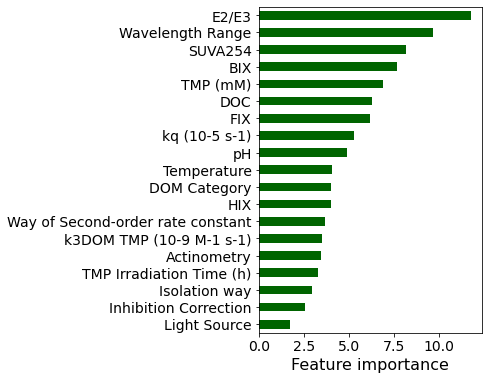

______________['Φ1O2']______________


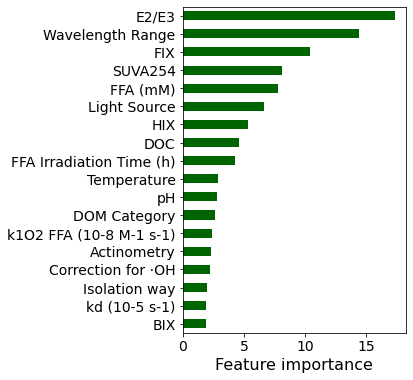

______________['Φ·OH']______________


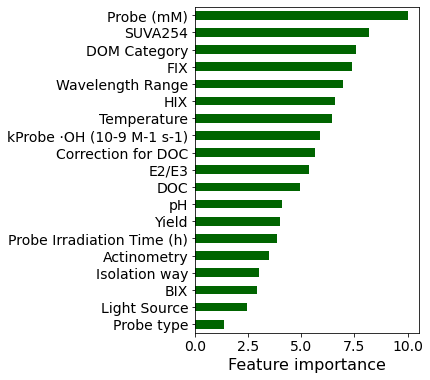

In [9]:
#Feature importance
for i in range(3):
    print("______________{}______________".format([ppris[i]]))
    fi = best_cbr[i].feature_importances_
    s = pd.Series(fi, trainx[i].columns)
    s.sort_values().plot.barh(color='darkgreen',figsize=[4,6])
    plt.xlabel("Feature importance", size=16)
    plt.tick_params(labelsize=14)
    plt.show()

______________['Φ3DOM*']______________


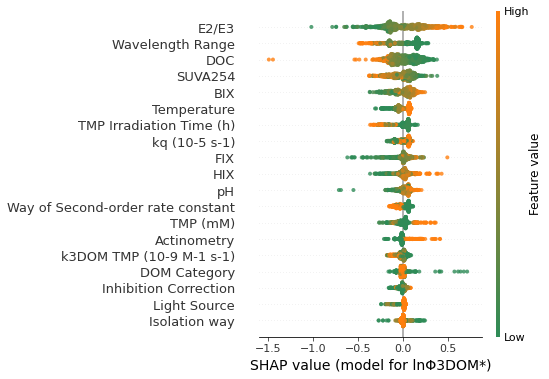

______________['Φ1O2']______________


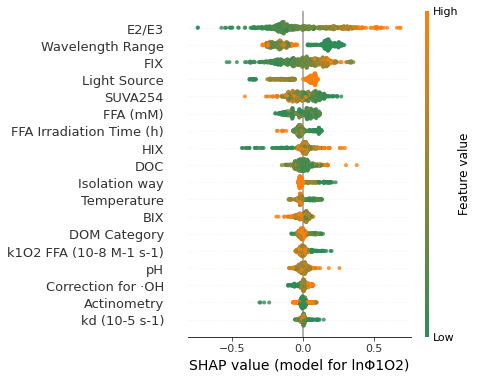

______________['Φ·OH']______________


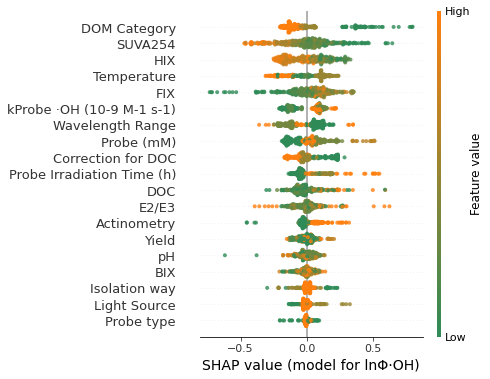

In [10]:
#SHAP summary plot
colors = ["seagreen","tab:orange"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)
for i in range(3):
    print("______________{}______________".format([ppris[i]]))
    explainer = shap.TreeExplainer(best_cbr[i])
    shap_values = explainer(trainx[i]) 
    shap.summary_plot(shap_values, trainx[i],show = False, feature_names=trainx[i].columns, cmap=cmap1,alpha=0.8, plot_size=(5,6))
    plt.xlabel('SHAP value (model for ln{})'.format(ppris[i]),size=14)
    plt.show()

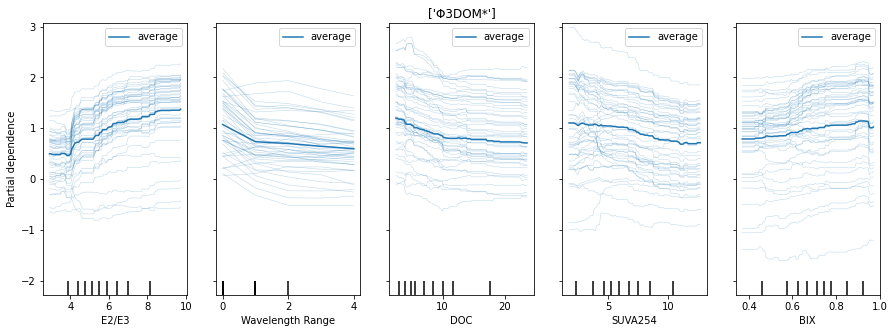

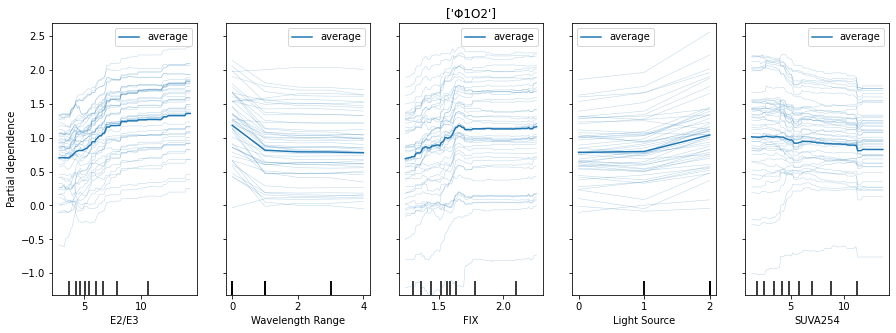

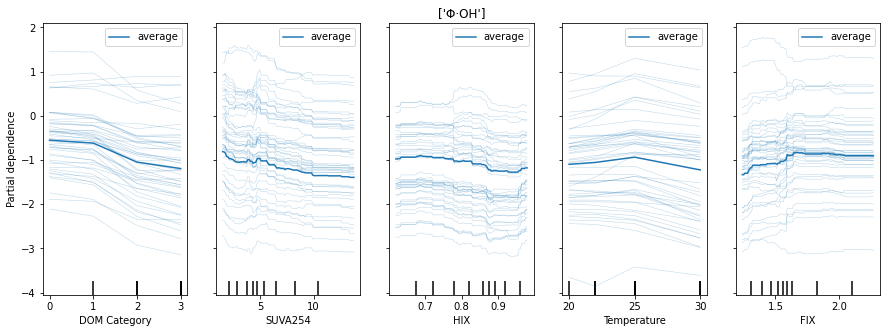

In [11]:
#PDP plot for the five most important features
features1 = ['E2/E3','Wavelength Range','DOC','SUVA254','BIX']
features2 = ['E2/E3','Wavelength Range','FIX','Light Source','SUVA254']
features3 = ['DOM Category','SUVA254','HIX','Temperature','FIX']
features = [features1,features2,features3]
for i in range(3):    
    fig,ax = plt.subplots(figsize=(15,5))
    plt.title(label=[ppris[i]])
    display1 = plot_partial_dependence(best_cbr[i], trainx[i], features[i], kind='both', subsample=50, grid_resolution=100,ax=ax,n_cols=5)

______________['Φ3DOM*']______________


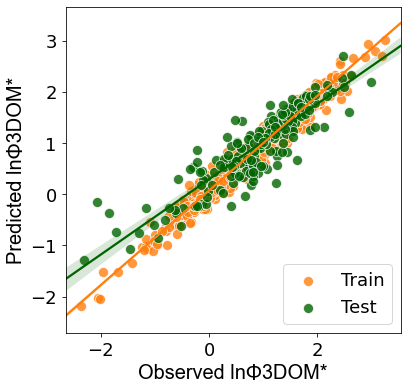

______________['Φ1O2']______________


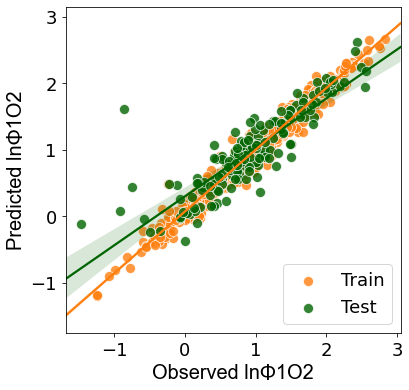

______________['Φ·OH']______________


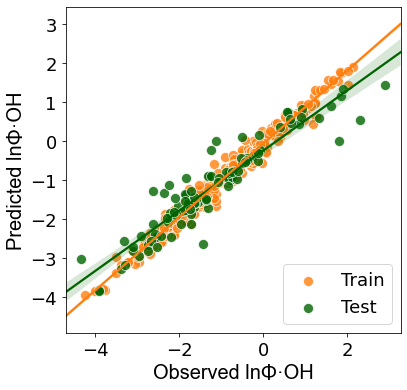

In [12]:
for i in range(3):
    print("______________{}______________".format([ppris[i]]))
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=trainy[i], y=best_cbr[i].predict(trainx[i]), s=100, color='tab:orange',  edgecolor='1',alpha=0.8)
    sns.scatterplot(x=testy[i], y=best_cbr[i].predict(testx[i]), s=100, color='darkgreen',  edgecolor='1',alpha=0.8)
    plt.legend(["Train", "Test"], loc='lower right', frameon=True, fontsize=18)
    sns.regplot(x=testy[i], y=best_cbr[i].predict(testx[i]), color='darkgreen',  scatter=False, truncate=False)
    sns.regplot(x=trainy[i], y=best_cbr[i].predict(trainx[i]), color='tab:orange', scatter=False, truncate=False)
    plt.tick_params(direction='out',length=4,width=0.8, labelsize=18, pad=5)

    plt.xlabel("Observed ln{}".format(ppris[i]), fontsize =20, fontname = 'Arial')
    plt.ylabel("Predicted ln{}".format(ppris[i]), fontsize =20, fontname = 'Arial')
    plt.show()

## Chain model 

In [13]:
#Singlet dataset
#Apply the imputation for the following features before predicting Φ3DOM*
df_singlet1 = df_singlet.copy()
df_singlet1['TMP (mM)'].fillna(value=0.005,inplace=True)
df_singlet1[ 'TMP Irradiation Time (h)'].fillna(value=1,inplace=True)
df_singlet1['Way of Second-order rate constant'].fillna(value=1,inplace=True)
df_singlet1['k3DOM TMP (10-9 M-1 s-1)'].fillna(value=0.81,inplace=True)
df_singlet1['Inhibition Correction'].fillna(value=1,inplace=True)
df_singlet1['kq (10-5 s-1)'].fillna(value=3,inplace=True)
df_singlet1.describe(include='all')

,Reference,DOM Category,Isolation way,Light Source,Wavelength Range,Actinometry,Temperature,pH,DOC,SUVA254,E2/E3,FIX,HIX,BIX,FFA (mM),FFA Irradiation Time (h),k1O2 FFA (10-8 M-1 s-1),kd (10-5 s-1),Correction for ·OH,TMP (mM),TMP Irradiation Time (h),Way of Second-order rate constant,k3DOM TMP (10-9 M-1 s-1),Inhibition Correction,kq (10-5 s-1),Φ1O2(10-2)
count,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000
mean,26.588235,2.295396,1.735294,1.690537,1.075448,2.561381,24.484655,7.182690,8.271323,5.858337,6.486385,1.591572,0.809055,0.700283,0.070703,2.694143,1.082302,2.581483,1.135550,0.135931,1.434591,0.767263,1.213469,0.906650,3.416591,3.407690
std,15.288829,0.926743,0.607471,0.573765,1.325679,0.918269,3.070098,1.037271,7.771183,4.205473,3.502887,0.322272,0.110228,0.210305,0.182398,3.639122,0.122063,0.158727,0.682347,0.291444,2.496774,0.422846,0.775815,0.554559,0.786215,2.512248
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,3.000000,0.590000,0.119526,1.685400,0.590000,0.240000,0.080000,0.010000,0.500000,0.830000,2.400000,0.000000,0.003670,0.500000,0.000000,0.540000,0.000000,2.520000,0.230000
25%,12.000000,2.000000,2.000000,1.000000,0.000000,2.000000,22.000000,7.000000,4.000000,2.973153,4.462250,1.400000,0.723132,0.550000,0.010000,1.500000,1.000000,2.500000,1.000000,0.005000,1.000000,1.000000,0.810000,1.000000,3.000000,1.645000
50%,25.000000,3.000000,2.000000,2.000000,1.000000,2.000000,25.000000,7.168800,5.035000,4.773605,5.440000,1.563350,0.832814,0.725735,0.022500,2.000000,1.090000,2.500000,1.000000,0.010000,1.000000,1.000000,0.810000,1.000000,3.000000,2.660000
75%,40.000000,3.000000,2.000000,2.000000,1.000000,4.000000,25.000000,7.937750,9.020000,7.645960,7.280000,1.697730,0.890000,0.829938,0.050000,2.000000,1.200000,2.760000,2.000000,0.030000,1.000000,1.000000,1.282500,1.000000,3.200000,4.467700
max,53.000000,3.000000,2.000000,2.000000,4.000000,4.000000,30.000000,9.700000,69.000000,27.313580,30.000000,3.110000,0.990000,2.250000,1.000000,32.000000,1.220000,2.900000,2.000000,1.000000,30.000000,1.000000,3.000000,2.000000,5.500000,17.020000


In [14]:
#Hydroxyl dataset
#Apply the imputation for the following features before predicting Φ3DOM*
df_hydroxyl1 = df_hydroxyl.copy()
df_hydroxyl1['TMP (mM)'].fillna(value=0.005,inplace=True)
df_hydroxyl1[ 'TMP Irradiation Time (h)'].fillna(value=1,inplace=True)
df_hydroxyl1['Way of Second-order rate constant'].fillna(value=1,inplace=True)
df_hydroxyl1['k3DOM TMP (10-9 M-1 s-1)'].fillna(value=0.81,inplace=True)
df_hydroxyl1['Inhibition Correction'].fillna(value=1,inplace=True)
df_hydroxyl1['kq (10-5 s-1)'].fillna(value=3,inplace=True)
df_hydroxyl1.describe(include='all')

,Reference,DOM Category,Isolation way,Light Source,Wavelength Range,Actinometry,Temperature,pH,DOC,SUVA254,E2/E3,FIX,HIX,BIX,Probe type,Probe (mM),Probe Irradiation Time (h),kProbe ·OH (10-9 M-1 s-1),Yield,Correction for DOC,TMP (mM),TMP Irradiation Time (h),Way of Second-order rate constant,k3DOM TMP (10-9 M-1 s-1),Inhibition Correction,kq (10-5 s-1),Φ·OH(10-4)
count,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000
mean,28.616803,2.512295,1.731557,1.811475,0.680328,2.530738,24.973361,7.361304,9.220985,6.171619,5.878944,1.592846,0.822610,0.661178,1.668033,1.049324,3.636578,5.031762,0.463238,0.975410,0.210795,1.631865,0.686475,1.358867,0.840164,3.557365,0.758458
std,15.970027,0.758154,0.594005,0.505931,0.984616,0.914787,3.320230,0.675591,8.756973,4.415798,2.901120,0.347329,0.118707,0.193127,0.544190,1.141716,12.071441,1.721693,0.199976,0.763254,0.348139,3.060802,0.464402,0.867759,0.671406,0.871436,1.475032
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,5.950000,0.590000,1.105440,1.823077,0.590000,0.240000,0.080000,0.000000,0.010000,0.500000,3.300000,0.155000,0.000000,0.003670,0.830000,0.000000,0.540000,0.000000,2.520000,0.013000
25%,12.000000,2.000000,2.000000,2.000000,0.000000,2.000000,22.000000,7.000000,4.000000,3.409610,4.287500,1.411560,0.746057,0.506217,1.000000,0.010000,1.000000,4.200000,0.350000,0.000000,0.005000,1.000000,0.000000,0.810000,0.000000,3.000000,0.136000
50%,36.000000,3.000000,2.000000,2.000000,0.000000,2.000000,25.000000,7.200000,6.687604,4.825000,5.247378,1.557125,0.860000,0.695160,2.000000,1.000000,1.000000,4.400000,0.350000,1.000000,0.010000,1.000000,1.000000,0.863000,1.000000,3.000000,0.310000
75%,44.000000,3.000000,2.000000,2.000000,1.000000,4.000000,25.000000,8.000000,9.838818,7.599925,6.800000,1.680050,0.900000,0.805524,2.000000,2.000000,1.000000,7.800000,0.630000,2.000000,0.500000,1.000000,1.000000,1.487500,1.000000,5.000000,0.680750
max,53.000000,3.000000,2.000000,2.000000,4.000000,4.000000,30.000000,9.700000,69.000000,27.313580,30.000000,3.110000,0.990000,1.100000,2.000000,3.000000,169.000000,7.800000,0.950000,2.000000,1.000000,30.000000,1.000000,3.000000,2.000000,5.500000,18.300000


In [15]:
#Split the dataset
tri_x2 = pd.concat([df_singlet1.iloc[:,1:14],df_singlet1.iloc[:,-7:-1]],axis=1)
x2 = df_singlet1.iloc[:,1:19]
tri_x3 = pd.concat([df_hydroxyl1.iloc[:,1:14],df_hydroxyl1.iloc[:,-7:-1]],axis=1)
x3 = df_hydroxyl1.iloc[:,1:20]
chain_df = [df_singlet1, df_hydroxyl1]
tri_x = [tri_x2, tri_x3]
newx = [x2,x3]
#Apply the predicted lnΦ3DOM* as a new feature of Φ1O2 and Φ·OH dataset
for i in range(2):
    newx[i]['Predicted ln3DOM']=best_cbr[0].predict(tri_x[i])
    newy = chain_df[i].iloc[:,-1].apply(np.log)
    ran_seed=42
    train_x, test_x, train_y, test_y = ms.train_test_split(newx[i], newy, test_size = 0.2, random_state = ran_seed)
    print("______________{}______________".format([ppris[i+1]]))
    display(train_x)
    trainx.append(train_x)
    testx.append(test_x)

______________['Φ1O2']______________


,DOM Category,Isolation way,Light Source,Wavelength Range,Actinometry,Temperature,pH,DOC,SUVA254,E2/E3,FIX,HIX,BIX,FFA (mM),FFA Irradiation Time (h),k1O2 FFA (10-8 M-1 s-1),kd (10-5 s-1),Correction for ·OH,Predicted ln3DOM
602,2,2,2,0,2,25,7.00,8.400000,1.335740,6.488095,1.820203,0.701482,0.867671,0.2000,1.50,1.00,2.50,1.0,1.298116
133,2,2,2,0,4,25,7.20,3.220000,10.227609,4.200000,1.280000,0.799591,0.758270,0.0225,2.00,1.20,2.50,2.0,0.942156
239,2,1,2,0,4,20,7.20,10.000000,5.296900,5.460000,1.518023,0.856010,0.607520,0.0225,2.00,1.20,2.50,1.0,0.706519
55,2,2,2,0,2,20,7.00,3.876712,16.811900,5.660000,1.576000,0.891000,0.776000,0.0500,2.00,1.00,2.76,1.0,1.180565
613,0,2,2,0,2,22,7.00,5.000000,9.626540,4.250000,1.318420,0.885710,0.443070,0.0500,1.33,1.00,2.50,1.0,1.557066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,3,2,2,1,2,30,6.81,3.910000,6.517490,6.000000,1.430000,0.900000,0.480000,0.0100,1.00,1.17,2.90,0.0,0.892110
106,3,2,0,4,2,25,7.50,4.500000,11.745300,4.400000,1.400000,0.782838,0.760611,0.0250,1.00,1.20,2.40,1.0,0.430155
270,3,2,2,1,4,25,7.80,3.240000,1.941429,4.280000,1.908212,0.736065,0.804072,1.0000,32.00,1.20,2.50,1.0,2.191349
435,2,2,2,0,2,20,3.00,5.000000,2.648450,13.270000,1.540408,0.718909,0.711287,0.0225,2.00,1.00,2.50,2.0,1.300875


______________['Φ·OH']______________


,DOM Category,Isolation way,Light Source,Wavelength Range,Actinometry,Temperature,pH,DOC,SUVA254,E2/E3,FIX,HIX,BIX,Probe type,Probe (mM),Probe Irradiation Time (h),kProbe ·OH (10-9 M-1 s-1),Yield,Correction for DOC,Predicted ln3DOM
415,1,0,2,0,2,22,8.00,8.49,3.062990,4.32,2.260000,0.550000,0.900000,2.0,1.00,0.67,3.3,0.350,0.0,0.327878
314,2,2,1,3,2,25,7.00,5.00,2.450392,8.82,1.898666,0.673809,0.864818,0.0,1.00,1.00,5.9,0.155,2.0,1.540183
25,3,2,2,1,2,30,5.95,4.49,8.336860,5.43,1.510000,0.940000,0.440000,2.0,0.01,1.00,4.2,0.420,1.0,0.523277
222,2,1,2,0,4,20,7.20,1.90,5.650000,3.25,1.060000,0.784149,0.785208,1.0,3.00,2.50,7.8,0.850,1.0,-0.367741
298,2,2,1,3,2,25,7.00,5.00,5.900286,4.96,1.520666,0.841440,0.686070,0.0,1.00,1.00,5.9,0.155,2.0,0.697287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,3,2,2,0,2,30,8.20,23.10,5.100000,9.70,1.561900,0.870880,0.710120,2.0,0.01,1.00,4.4,0.350,0.0,1.540578
270,3,2,2,1,2,25,6.50,4.00,2.400000,7.39,1.250000,0.860000,0.370000,2.0,0.01,1.00,4.2,0.370,1.0,-0.985463
348,0,2,2,0,2,20,6.90,10.00,10.421075,3.50,1.367700,0.829216,0.615900,2.0,0.01,169.00,3.3,0.350,2.0,0.702939
435,3,2,2,0,2,22,8.20,12.39,1.796340,5.50,2.600000,0.610000,0.990000,2.0,1.00,0.67,3.3,0.350,0.0,0.432991


In [16]:
#Model performance with default hyperparameters
#Ensemble learning models 
estimators = [se.RandomForestRegressor(random_state=ran_seed),
             se.GradientBoostingRegressor(random_state=ran_seed),
             xgb.XGBRegressor(random_state=ran_seed),
             lgb.LGBMRegressor(random_state=ran_seed),
             cb.CatBoostRegressor(random_state=ran_seed, verbose=False)]
name = ['RF','GBDT','XGB','LGB','CB']
for i in range(2):
    print("______________{}______________".format([ppris[i+1]]))
    model_results=[]
    index_name =[]
    for n in range(len(estimators)):
        model = estimators[n]
        model.fit(trainx[i+3], trainy[i+1])

        scores = ms.cross_validate(model, trainx[i+3], trainy[i+1], cv=5, scoring=['r2','neg_root_mean_squared_error'])
        pred_train_y = model.predict(trainx[i+3])
        train_rmse = math.sqrt(sm.mean_squared_error(trainy[i+1], pred_train_y))

        index_name.append('{} default'.format(name[n]))
        model_results.append(np.array([model.score(trainx[i+3], trainy[i+1]),scores.get('test_r2').mean(),
                                        train_rmse, -scores.get('test_neg_root_mean_squared_error').mean()]))
    total_model_results = pd.DataFrame(model_results, index=index_name, columns=['train_R2','cv_R2','train_rmse','cv_rmse'])
    display(total_model_results)

______________['Φ1O2']______________


,train_R2,cv_R2,train_rmse,cv_rmse
RF default,0.970020,0.767076,0.125473,0.348404
GBDT default,0.924795,0.762618,0.198729,0.351671
XGB default,0.999850,0.750801,0.008881,0.360417
LGB default,0.972482,0.777023,0.120212,0.341079
CB default,0.986260,0.802685,0.084944,0.320561


______________['Φ·OH']______________


,train_R2,cv_R2,train_rmse,cv_rmse
RF default,0.961796,0.722775,0.227438,0.599641
GBDT default,0.937733,0.718992,0.290361,0.603178
XGB default,0.999972,0.743158,0.006207,0.580348
LGB default,0.964070,0.733335,0.220564,0.589057
CB default,0.990796,0.792264,0.111631,0.520530


## Chain CatBoost

In [17]:
#The developed chain model will be exported as a pickle named "Tri-singlet.pickle" or "Tri-hydroxyl.pickle" for the further application
ppris = ["Φ3DOM*","Φ1O2","Φ·OH"]
chain_cbr = [cb.CatBoostRegressor(random_state=42, verbose=False,iterations=350,rsm=0.4,learning_rate=0.08,subsample=0.8,
                                   random_strength=64),
             cb.CatBoostRegressor(random_state=42, verbose=False,iterations=360, learning_rate=0.1,rsm=0.1,random_strength=99)]
for i in range(2):
    print("______________{}______________".format([ppris[i+1]]))
    chain_cbr[i].fit(trainx[i+3], trainy[i+1])
    pred_train_y = chain_cbr[i].predict(trainx[i+3])
    pred_test_y = chain_cbr[i].predict(testx[i+3])

    scores = ms.cross_validate(chain_cbr[i], trainx[i+3], trainy[i+1], cv=5, scoring=['r2','neg_root_mean_squared_error'])
    test_r = chain_cbr[i].score(testx[i+3], testy[i+1])
    train_r = chain_cbr[i].score(trainx[i+3], trainy[i+1])
    train_rmse = math.sqrt(sm.mean_squared_error(trainy[i+1], pred_train_y))
    test_rmse = math.sqrt(sm.mean_squared_error(testy[i+1], pred_test_y))
    cv_R2 = scores.get('test_r2').mean()
    cv_RMSE = -scores.get('test_neg_root_mean_squared_error').mean()

    print('Chain CatBoost for {}:'.format(ppris[i+1]))
    print(best_cbr[i].get_all_params())
    print('\n R2  Train: {:.4f}'.format(train_r), ' Test: {:.4f}'.format(test_r), 
          ' CV: {:.4f} (+/- {:.4f})'.format(cv_R2,scores.get('test_r2').std()))
    print('RMSE Train: {:.4f}'.format(train_rmse),' Test: {:.4f}'.format(test_rmse), 
          ' CV: {:.4f} (+/- {:.4f})\n'.format(cv_RMSE, scores.get('test_neg_root_mean_squared_error').std())) 

______________['Φ1O2']______________
Chain CatBoost for Φ1O2:
{'nan_mode': 'Min', 'eval_metric': 'RMSE', 'iterations': 300, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 6, 'rsm': 0.30000001192092896, 'boost_from_average': True, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'use_best_model': False, 'random_seed': 42, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'RMSE', 'learning_rate': 0.109999999403

______________['Φ1O2']______________


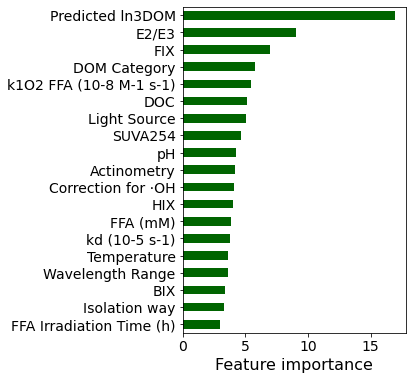

______________['Φ·OH']______________


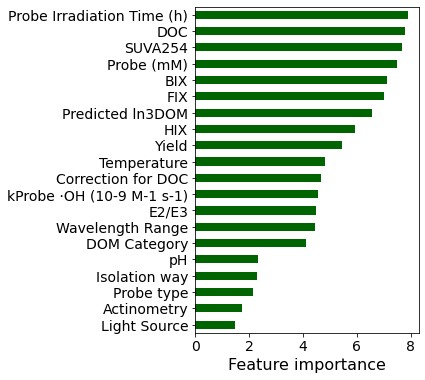

In [18]:
#Feature importance
for i in range(2):
    print("______________{}______________".format([ppris[i+1]]))
    fi = chain_cbr[i].feature_importances_
    s = pd.Series(fi, trainx[i+3].columns)

    s.sort_values().plot.barh(color='darkgreen',figsize=[4,6])
    plt.xlabel("Feature importance", size=16)
    plt.tick_params(labelsize=14)
    plt.show()

______________['Φ1O2']______________


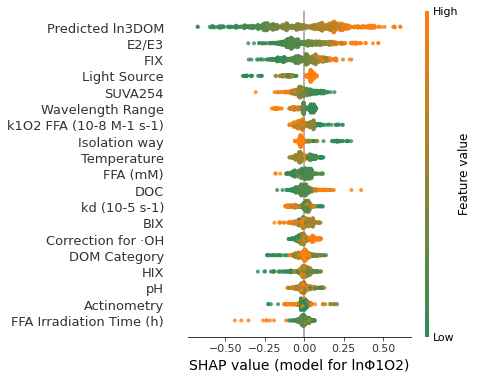

______________['Φ·OH']______________


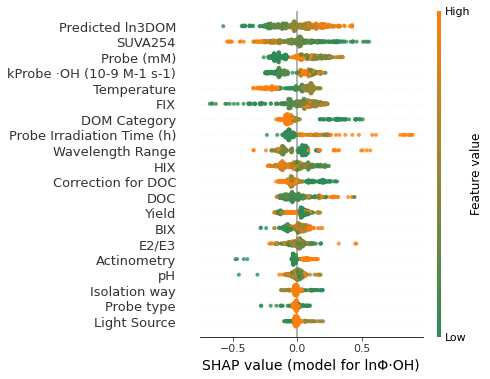

In [19]:
#SHAP summary plot
colors = ["seagreen","tab:orange"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)
for i in range(2):
    print("______________{}______________".format([ppris[i+1]]))
    explainer = shap.TreeExplainer(chain_cbr[i])
    shap_values = explainer(trainx[i+3]) 
    shap.summary_plot(shap_values, trainx[i+3],show = False, feature_names=trainx[i+3].columns, cmap=cmap1,alpha=0.8, plot_size=(5,6))
    plt.xlabel('SHAP value (model for ln{})'.format(ppris[i+1]),size=14)
    plt.show()

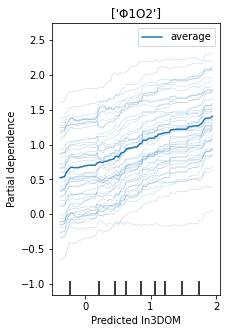

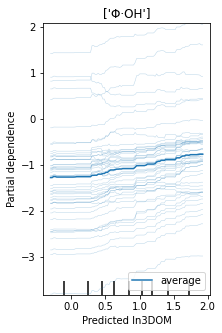

In [20]:
#PDP plot for the five most important features
for i in range(2):    
    fig,ax = plt.subplots(figsize=(3,5))
    plt.title(label=[ppris[i+1]])
    display1 = plot_partial_dependence(chain_cbr[i], trainx[i+3], ['Predicted ln3DOM'], kind='both', subsample=50, grid_resolution=100,ax=ax)

______________['Φ1O2']______________


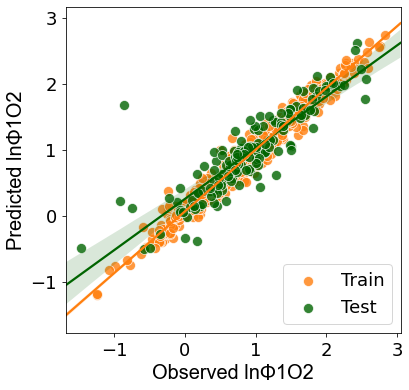

______________['Φ·OH']______________


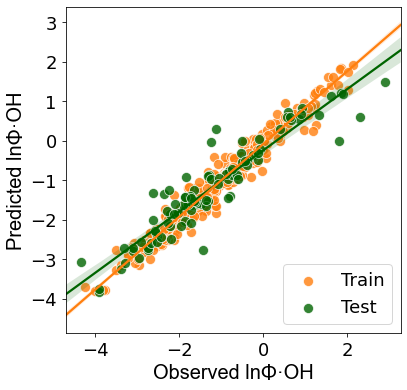

In [21]:
for i in range(2):
    print("______________{}______________".format([ppris[i+1]]))
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=trainy[i+1], y=chain_cbr[i].predict(trainx[i+3]), s=100, color='tab:orange',  edgecolor='1',alpha=0.8)
    sns.scatterplot(x=testy[i+1], y=chain_cbr[i].predict(testx[i+3]), s=100, color='darkgreen',  edgecolor='1',alpha=0.8)
    plt.legend(["Train", "Test"], loc='lower right', frameon=True, fontsize=18)
    sns.regplot(x=testy[i+1], y=chain_cbr[i].predict(testx[i+3]), color='darkgreen',  scatter=False, truncate=False)
    sns.regplot(x=trainy[i+1], y=chain_cbr[i].predict(trainx[i+3]), color='tab:orange', scatter=False, truncate=False)
    plt.tick_params(direction='out',length=4,width=0.8, labelsize=18, pad=5)

    plt.xlabel("Observed ln{}".format(ppris[i+1]), fontsize =20, fontname = 'Arial')
    plt.ylabel("Predicted ln{}".format(ppris[i+1]), fontsize =20, fontname = 'Arial')
    plt.show()